# Applicazione di metodi Monte Carlo NVT:

Sfruttando il codice Monte Carlo NVT fornito, analizzare, a seguito di una equilibrazione arbitraria, lo sviluppo della simulazione di tre fasi termodinamiche note di un sistema nei primi $10^5$ passi di simulazione.

In particolare studiare l'autocorrelazione dei valori istantanei di Energia potenziale per particella (U/N) e di Pressione; inoltre risuddividere i $5$*$10^5$ steps di simulazione analizzati in blocchi di lunghezza variabile L in un range arbitrario [10,5000], ed osservare l'andamento dell'incertezza stimata mendiate medie di blocco all'aumentare di L.

Le fasi termodinamiche coinvolte sono:
- fase solida: $\rho^\star = 1.1$, $T^\star = 0.8$,  $R_{cut-off} = 2.2$;
- fase liquida: $\rho^\star = 0.8$, $T^\star = 1.1$, $R_{cut-off} = 2.5$;
- fase gassosa: $\rho^\star = 0.05$, $T^\star = 1.2$, $R_{cut-off} = 5.0$;

#### - Autocorrelazione:
Si scrivano alcune funzioni statistiche elementari che torneranno utili per entrambe le richieste di analisi dati.

In [1]:

import math


def Media (X, i, z) :              #attenzione: z è la posizione nell'array
    return sum( X[i:z+1] )/(z-i+1)

def Err (X, i, z):                #attenzione z è la posizione nell'array, vale N=(z+1) ovvero (N-1)=z
    if z==i :
        return 0
    return math.sqrt( (Media(X**2,i,z) - Media(X,i,z)**2) / z )


Si definisca ora la funzione di autocorrelazione che si desidera studiare.

$$ cov_{[x_i,x_j]} := \langle x_i(t_1)x_j(t_2) \rangle - \langle x_i(t_1) \rangle \langle x_j(t_2) \rangle$$

$$ Ac_{[x]}(\tau) := \frac{cov_{[x,x]}(t,t+\tau)}{\sqrt{cov_{[x,x]}(t,t)}\sqrt{cov_{[x,x]}(t+\tau,t+\tau)}} = \frac{cov_{[x,x]}(t,t+\tau)}{cov_{[x,x]}(t,t)} = \frac{ \langle x(t)x(t+\tau) \rangle - \langle x(t) \rangle \langle x(t+\tau) \rangle }{\sigma^2_x}$$

Sia quindi il tempo da considerasi come singolo step della simulazione Monte Carlo.\
Si definisce un tempo massimo di analisi $(t_{max})$ pari a 10'000 steps di simulazione per efficienza computazionale e si riscrive quindi la definizione precedente secondo:

$$Ac(\tau)= \frac{\frac{1}{t_{max}-\tau}\sum^{t_{max}-\tau}_{t'=0}x(t')x(t'+\tau)-\frac{1}{t_{max}-\tau}\sum^{t_{max}-\tau}_{t'=0}x(t')*\frac{1}{t_{max}-\tau}\sum^{t_{max}-\tau}_{t'=0}x(t'+\tau)}{\frac{1}{t_{max}}\sum^{t_{max}}_{t'=0}x^2(t')-(\frac{1}{t_{max}}\sum^{t_{max}}_{t'=0}x(t'))^2}$$


In [2]:

def Autocorr (X, tmax):
    
    Ac= numpy.zeros( tmax )
    A= numpy.zeros( tmax )
    B= numpy.zeros( tmax )
    C= numpy.zeros( tmax )
    D= Media(X**2,0,tmax+1)        
    E= Media(X,0,tmax-1)**2    
    
    for j in range( tmax ):
        for i in range ( tmax-j ):
            A[j]+= X[i]*X[i+j]
            B[j]+= X[i]
            C[j]+= X[i+j]        
        A[j]/= (tmax-j)
        B[j]/= (tmax-j)
        C[j]/= (tmax-j)
    

    for i in range( numpy.size(Ac) ):                      #stima della Acarianza
        Ac[i]= ( A[i] - B[i]*C[i] ) / ( D - E )
        
    return Ac
    

Per ognuno delle osservabili termodinamiche coinvolte e per ogni fase coinvolta produrre un grafico della funzione di autocorrelazione così da valutare il numero di steps di simulazione necessari a produrre configurazione statisticamente indipendenti tra loro.

##### Fase solida:

In [3]:

import numpy


E_s = numpy.loadtxt( "7.1/output.epot.solid.txt", usecols= (1), delimiter= "\t", unpack= 'true' )
P_s = numpy.loadtxt( "7.1/output.pres.solid.txt", usecols= (1), delimiter= "\t", unpack= 'true' )


In [4]:

Ac_E_s= Autocorr (E_s,10000)
Ac_P_s= Autocorr (P_s,10000)


Per compattezza di visualizzazione si produce un grafico delle autocorrelazioni dei soli primi 300 elementi, consci di poter osservare un andamento delineato già in questo range.

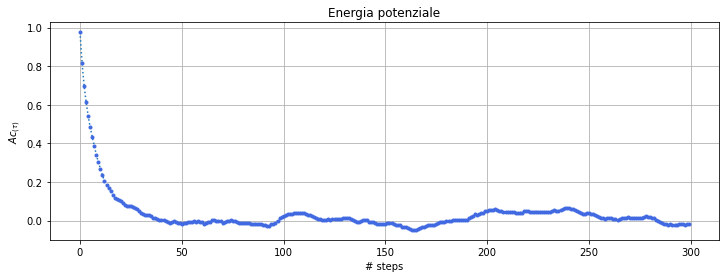

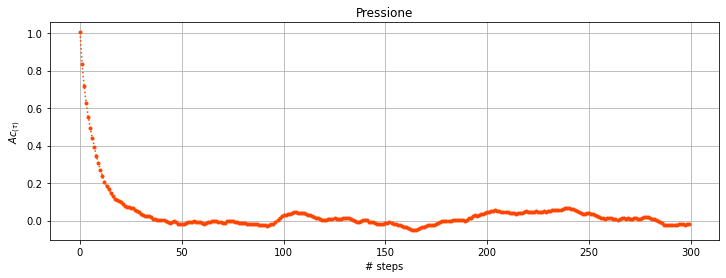

In [5]:

import matplotlib.pyplot as plt

N = numpy.arange ( 300 )   

plt.figure(figsize=(12, 4))
plt.plot( N, Ac_E_s[:300], marker= 'o', mfc= 'royalblue', mec= 'royalblue', ms= 3, linestyle= ":" )
plt.xlabel('# steps')
plt.ylabel(r'$Ac_{(\tau)}$')
plt.title( "Energia potenziale" )
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 4))
plt.plot( N, Ac_P_s[:300], marker= 'o', mfc= 'orangered', mec= 'orangered', ms= 3, linestyle= ":", 
          color= "orangered" )
plt.xlabel('# steps')
plt.ylabel(r'$Ac_{(\tau)}$')
plt.title( "Pressione" )
plt.grid(True)
plt.show()


Come si può osservare ad una distanza in steps di simulazione di circa 200-300, la funzione di autocorrelazione tende a zero, per poi oscillare intorno a tale valore; a tale distanza si possono quindi considerare le configurazioni prodotte dalla simulazione come indipendenti.\
Costruire quindi dei blocchi per l'algoritmo di media a blocchi di tale o superiore dimensione garantisce la scorrelazione all'interno del blocco stesso e a maggior ragione tra blocchi attigui.

##### Fase liquida:

In [6]:

E_l = numpy.loadtxt( "7.1/output.epot.liquid.txt", usecols= (1), delimiter= "\t", unpack= 'true' )
P_l = numpy.loadtxt( "7.1/output.pres.liquid.txt", usecols= (1), delimiter= "\t", unpack= 'true' )


In [7]:

Ac_E_l= Autocorr (E_l,10000)
Ac_P_l= Autocorr (P_l,10000)


Per semplicità di visulizzazione si grafica l'autocorrelazione nei soli primi 300 steps simulativi.

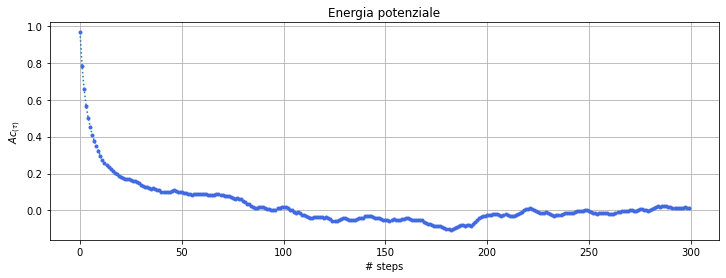

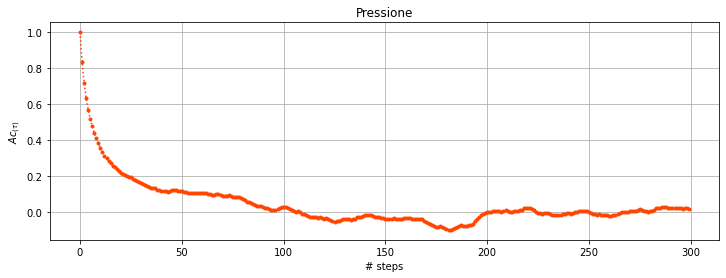

In [8]:

plt.figure(figsize=(12, 4))
plt.plot( N, Ac_E_l[:300], marker= 'o', mfc= 'royalblue', mec= 'royalblue', ms= 3, linestyle= ":" )
plt.xlabel('# steps')
plt.ylabel(r'$Ac_{(\tau)}$')
plt.title( "Energia potenziale" )
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 4))
plt.plot( N, Ac_P_l[:300], marker= 'o', mfc= 'orangered', mec= 'orangered', ms= 3, linestyle= ":", 
          color= "orangered" )
plt.xlabel('# steps')
plt.ylabel(r'$Ac_{(\tau)}$')
plt.title( "Pressione" )
plt.grid(True)
plt.show()


Sulla precedente scala scelta è visibile un andamento verso un valore nullo dell'autocorrelazione a seguito di qualche centinaio di passi, per poi fluttuare intorno a tale valore.


###### Fase gassosa:

In [9]:

E_g = numpy.loadtxt( "7.1/output.epot.gas.txt", usecols= (1), delimiter= "\t", unpack= 'true' )
P_g = numpy.loadtxt( "7.1/output.pres.gas.txt", usecols= (1), delimiter= "\t", unpack= 'true' )


In [10]:

Ac_E_g= Autocorr (E_g,10000)
Ac_P_g= Autocorr (P_g,10000)


Si produce un grafico sull'autocorrelazione per i solo primi 300 steps di simulazione.


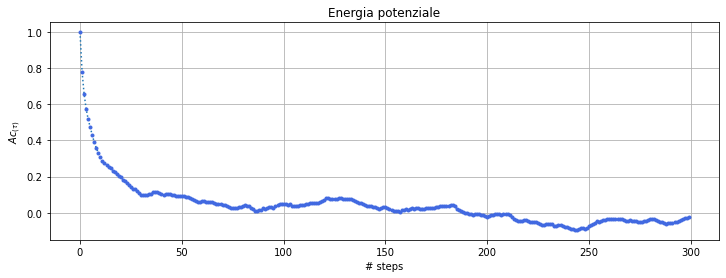

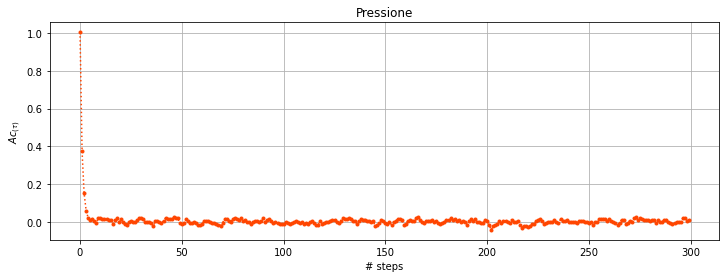

In [11]:

plt.figure(figsize=(12, 4))
plt.plot( N, Ac_E_g[:300], marker= 'o', mfc= 'royalblue', mec= 'royalblue', ms= 3, linestyle= ":" )
plt.xlabel('# steps')
plt.ylabel(r'$Ac_{(\tau)}$')
plt.title( "Energia potenziale" )
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 4))
plt.plot( N, Ac_P_g[:300], marker= 'o', mfc= 'orangered', mec= 'orangered', ms= 3, linestyle= ":", 
          color= "orangered" )
plt.xlabel('# steps')
plt.ylabel(r'$Ac_{(\tau)}$')
plt.title( "Pressione" )
plt.grid(True)
plt.show()

L'andamento osservabile rispecchia quanto descritto per le precedenti fasi simulate.

In questo stato di materia, addirittura, il comportamento è tale che il sistema libero di evolversi esplora configurazioni in cui le pressioni risultano scorrelate persino a meno di una decina di simulazioni consecutive.

#### - Impacchettamento a blocchi:
Per ogni fase, per ogni osservabile coinvolta, costruire dei blocchi di lunghezza L variabile in [10,5000] a partire dai $5$*$10^5$ steps simulativi precedentemente ottenuti, al fine di meglio visualizzare l'andamento dell'errore stimato tramite l'applicazione di un algoritmo statistico di media a blocchi.

Si ponga particolare attenzione:
1) si utilizzino valori di L appropriati (ovvero divisori di $5$*$10^5$);\
2) si utilizzi una scala consona per visualizzare concretamente i risultati;\
3) ci si attende una stabilizzazione dell'errore o almeno una sua attestazione entro valori coerenti con il valor medio relativo, una volta giunti oltre i 200/300 steps simulativi per blocco;

##### Fase solida:


Energia Potenziale per particella:



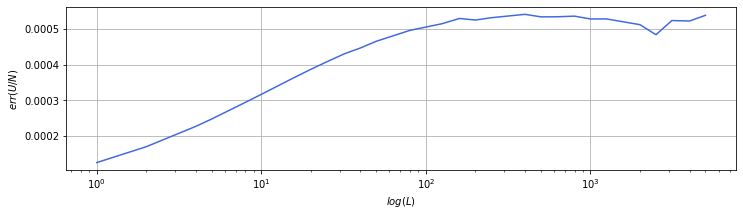

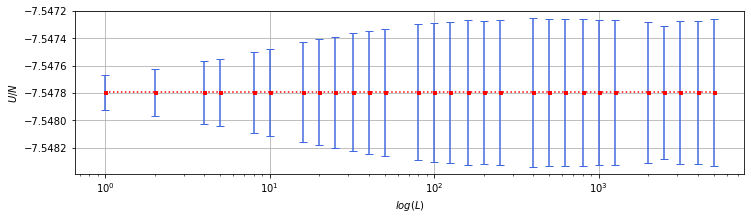

In [12]:

L= [] 
AvL_E_s= []
errAvL_E_s= []

for i in range (1,5001):
    if (500000.%float(i) == 0):
        L.append(i) 
        
for j in L:
    M= numpy.size(E_s)/j
    EM_s= numpy.zeros( int(M) )
    for i in range ( int(M) ):
        EM_s[i]= Media(E_s,int(j*i),int(j*(i+1)-1))   
    AvL_E_s.append( Media(EM_s,0,int(M)-1) )
    errAvL_E_s.append( Err(EM_s,0,int(M)-1) )
    
print ( "\nEnergia Potenziale per particella:\n")    

plt.figure(figsize=(12, 3))
plt.plot(L, errAvL_E_s, color= "royalblue")
plt.xlabel(r'$log(L)$')
plt.xscale('log')
plt.ylabel(r'$err(U/N)$')
plt.grid(True)

plt.figure(figsize=(12, 3))
plt.errorbar( L, AvL_E_s, yerr= errAvL_E_s, capsize= 4, marker= 's', mfc= 'red', mec= 'red', ms= 3, 
             linestyle= ":", color= "red", ecolor= "royalblue")
plt.xlabel(r'$log(L)$')
plt.xscale('log')
plt.ylabel(r'$U/N$')
plt.grid(True)

plt.show()



Pressione:



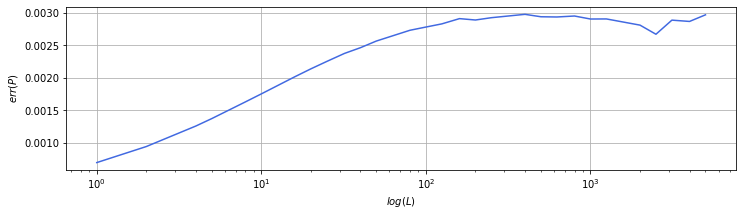

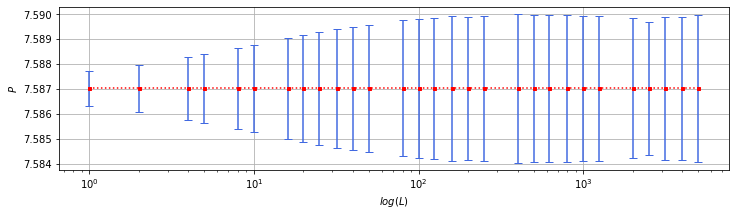

In [13]:

AvL_P_s= []
errAvL_P_s= []

for j in L:
    M= numpy.size(P_s)/j
    PM_s= numpy.zeros( int(M) )
    for i in range ( int(M) ):
        PM_s[i]= Media(P_s,int(j*i),int(j*(i+1)-1))
    AvL_P_s.append( Media(PM_s,0,int(M)-1) )
    errAvL_P_s.append( Err(PM_s,0,int(M)-1) )
    
print ("\nPressione:\n")

plt.figure(figsize=(12, 3))
plt.plot( L, errAvL_P_s, color= "royalblue")
plt.xlabel(r'$log(L)$')
plt.xscale('log')
plt.ylabel(r'$err(P)$')
plt.grid(True)
 
plt.figure(figsize=(12, 3))
plt.errorbar( L, AvL_P_s, yerr= errAvL_P_s, capsize= 4, marker= 's', mfc= 'red', mec= 'red', ms= 3, 
              linestyle= ":", color= "red", ecolor= "royalblue")
plt.xlabel(r'$log(L)$')
plt.xscale('log')
plt.ylabel(r'$P$')
plt.grid(True)

plt.show()


Come atteso, l'errore si stabilizza nel momento in cui nel gruppo cade l'autocorrelazione delle configurazioni (oltre 200-300 steps).

##### Fase liquida:
Analogamente si procede con il rielaborare la simulazione della fase liquida. 


Energia Potenziale per particella:



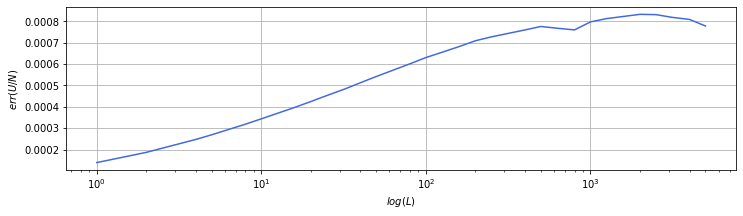

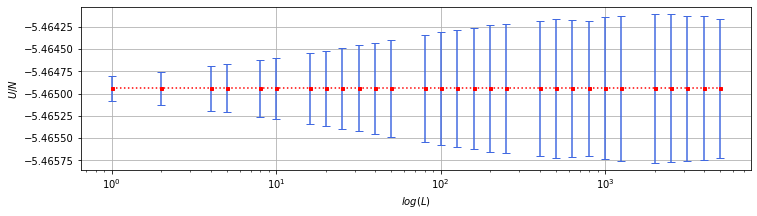

In [14]:

AvL_E_l= []
errAvL_E_l= []

for j in L:
    M= numpy.size(E_l)/j
    EM_l= numpy.zeros( int(M) )
    for i in range ( int(M) ):
        EM_l[i]= Media(E_l,int(j*i),int(j*(i+1)-1))
    AvL_E_l.append( Media(EM_l,0,int(M)-1) )
    errAvL_E_l.append( Err(EM_l,0,int(M)-1) )
    
print("\nEnergia Potenziale per particella:\n")
    
plt.figure(figsize=(12, 3))
plt.plot( L, errAvL_E_l, color= "royalblue")
plt.xlabel(r'$log(L)$')
plt.xscale('log')
plt.ylabel(r'$err(U/N)$')
plt.grid(True)    
    
    
plt.figure(figsize=(12, 3))
plt.errorbar( L, AvL_E_l, yerr= errAvL_E_l, capsize= 4, marker= 's', mfc= 'red', mec= 'red', ms= 3, 
              linestyle= ":", color= "red", ecolor= "royalblue")
plt.xlabel(r'$log(L)$')
plt.xscale('log')
plt.ylabel(r'$U/N$')
plt.grid(True)

plt.show()



Pressione:



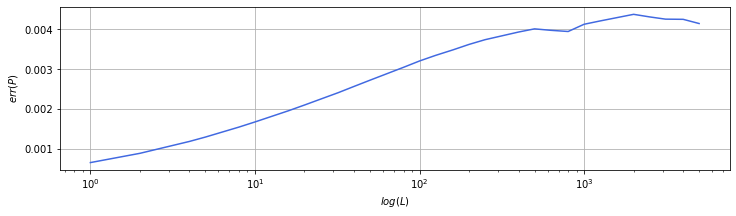

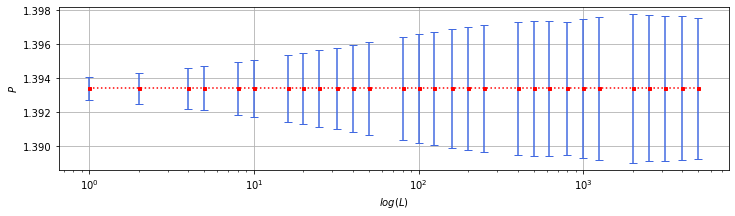

In [15]:

AvL_P_l= []
errAvL_P_l= []

for j in L:
    M= numpy.size(P_l)/j
    PM_l= numpy.zeros( int(M) )
    for i in range ( int(M) ):
        PM_l[i]= Media(P_l,int(j*i),int(j*(i+1)-1))
    AvL_P_l.append( Media(PM_l,0,int(M)-1) )
    errAvL_P_l.append( Err(PM_l,0,int(M)-1) )
    
print( "\nPressione:\n" )
    
plt.figure(figsize=(12, 3))
plt.plot( L, errAvL_P_l, color= "royalblue" )
plt.xlabel(r'$log(L)$')
plt.xscale('log')
plt.ylabel(r'$err(P)$')
plt.grid(True)
    
    
plt.figure(figsize=(12,3))
plt.errorbar( L, AvL_P_l, yerr= errAvL_P_l, capsize= 4, marker= 's', mfc= 'red', mec= 'red', ms= 3, 
              linestyle= ":", color= "red", ecolor= "royalblue")
plt.xlabel(r'$log(L)$')
plt.xscale('log')
plt.ylabel(r'$P$')
plt.grid(True)

plt.show()


Si nota quanto in precedenza.

##### Fase gassosa:
Infine per la fase gassosa si rielabora come segue:


Energia Potenziale:



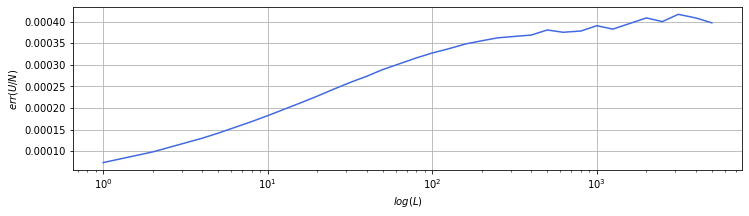

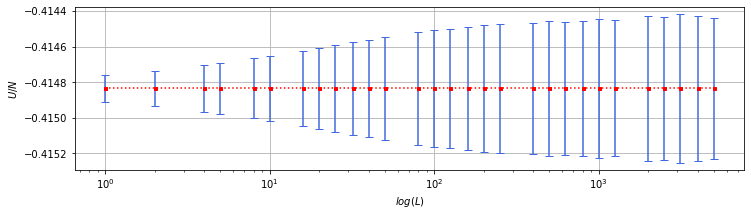

In [16]:

AvL_E_g= []
errAvL_E_g= []

for j in L:
    M= numpy.size(E_g)/j
    EM_g= numpy.zeros( int(M) )
    for i in range ( int(M) ):
        EM_g[i]= Media(E_g,int(j*i),int(j*(i+1)-1))
    AvL_E_g.append( Media(EM_g,0,int(M)-1) )
    errAvL_E_g.append( Err(EM_g,0,int(M)-1) )
  
print("\nEnergia Potenziale:\n")    
    
plt.figure(figsize=(12, 3))
plt.plot( L, errAvL_E_g, color= "royalblue")
plt.xlabel(r'$log(L)$')
plt.xscale('log')
plt.ylabel(r'$err(U/N)$')
plt.grid(True)
    
    
plt.figure(figsize=(12,3))
plt.errorbar( L, AvL_E_g, yerr= errAvL_E_g, capsize= 4, marker= 's', mfc= 'red', mec= 'red', ms= 3, 
              linestyle= ":", color= "red", ecolor= "royalblue")
plt.xlabel(r'$log(L)$')
plt.xscale('log')
plt.ylabel(r'$U/N$')
plt.grid(True)

plt.show()



Pressione:



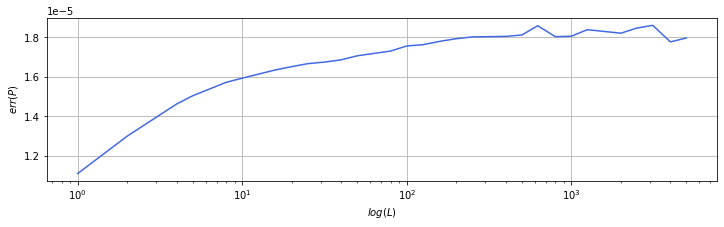

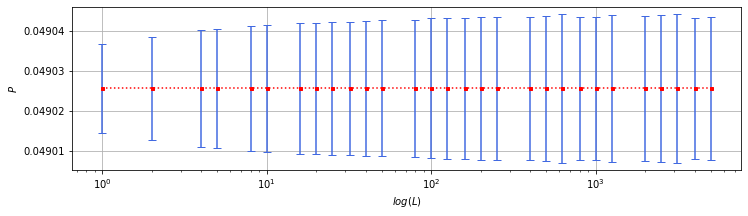

In [17]:

AvL_P_g= []
errAvL_P_g= []

for j in L:
    M= numpy.size(P_g)/j
    PM_g= numpy.zeros( int(M) )
    for i in range ( int(M) ):
        PM_g[i]= Media(P_g,int(j*i),int(j*(i+1)-1))
    AvL_P_g.append( Media(PM_g,0,int(M)-1) )
    errAvL_P_g.append( Err(PM_g,0,int(M)-1) )

print("\nPressione:\n")
    
plt.figure(figsize=(12, 3))
plt.plot( L, errAvL_P_g, color= "royalblue")
plt.xlabel(r'$log(L)$')
plt.xscale('log')
plt.ylabel(r'$err(P)$')
plt.grid(True)

plt.figure(figsize=(12, 3))
plt.errorbar( L, AvL_P_g, yerr= errAvL_P_g, capsize= 4, marker= 's', mfc= 'red', mec= 'red', ms= 3, 
              linestyle= ":", color= "red", ecolor= "royalblue")
plt.xlabel(r'$log(L)$')
plt.xscale('log')
plt.ylabel(r'$P$')
plt.grid(True)

plt.show()


Analogamente a quanto in precedenza.

Per quanto riguarda la pressione, l'errore stabilizza in maniera decisamente più rapida in accordo con il grafico mostrato in precedenza per la fase gassosa.

### -----------------------------------------------------------------------------------------------------------------------------------------------------------

# Metodi Monte Carlo NVT (parte seconda):

Implementare nel codice precedente la stima, con relativa incertezza, della funzione di distribuzione di struttura $g(r)$ (conosciuta la quale è possibile ricavare qualsiasi quantità termodinamica di interesse) come funzione della distanza reciproca tra le particelle $r \in [0,box/2]$, dove $box$ è la dimensione del cubo di simulazione utilizzato.\
Inoltre, fissati i seguenti parametri per l'algoritmo di media a blocchi, graficare nel numero di blocchi i valori e relativi errori delle variabili termodinamiche di interesse $(U/M, p)$ :
- L= 5000 simulazioni per blocco;
- N= 100 blocchi;

##### Fase solida:
Si analizza l'intera simulazione riassumendo i risultati con adeguati grafici.

In [18]:

E_s, errE_s, P_s, errP_s= numpy.loadtxt( "7.2/out.solid.txt", usecols= (2,3,5,6), delimiter= "\t", 
                                         unpack= 'true' )
r_g, G_s, errG_s= numpy.loadtxt( "7.2/out.g(x).solid.txt", usecols= (0,2,3), delimiter= "\t", unpack= 'true' )


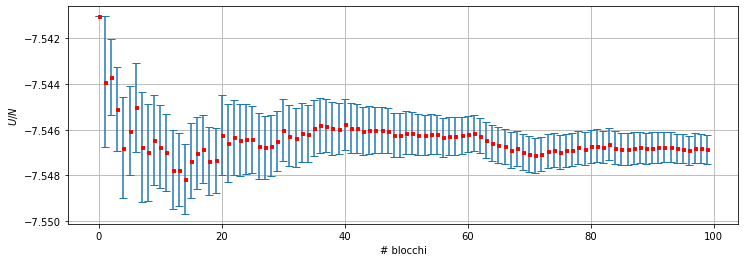

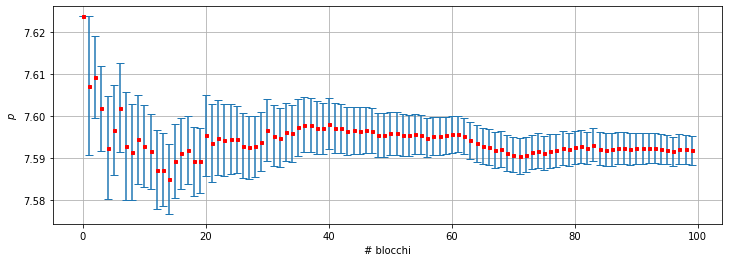

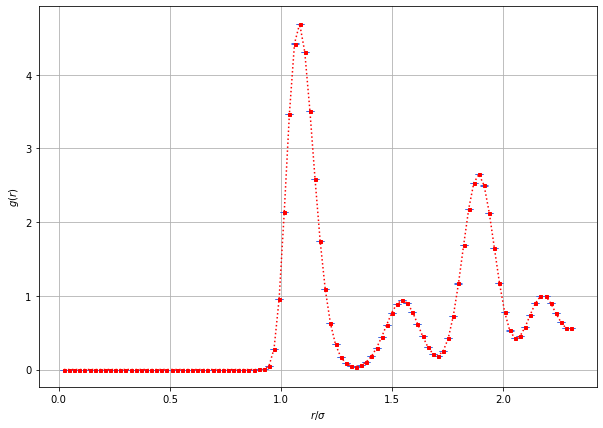

In [19]:

N= numpy.arange(numpy.size(E_s))

plt.figure(figsize=(12, 4))
plt.errorbar( N, E_s, yerr= errE_s, capsize= 4, marker= 's', mfc= 'red', mec= 'red', ms= 3, 
              linestyle= "none")
plt.xlabel('# blocchi')
plt.ylabel(r'$U/N$')
plt.grid(True)

plt.figure(figsize=(12, 4))
plt.errorbar( N, P_s, yerr= errP_s, capsize= 4, marker= 's', mfc= 'red', mec= 'red', ms= 3, 
              linestyle= "none")
plt.xlabel('# blocchi')
plt.ylabel(r'$p$')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 7))
plt.errorbar( r_g, G_s, yerr= errG_s, capsize= 4, marker= 's', mfc= 'red', mec= 'red', ms= 3, 
              linestyle= ":", ecolor= 'royalblue', color= "red")

plt.xlabel(r'$r/\sigma$')
plt.ylabel(r'$g(r)$')
plt.grid(True)

plt.show()


I grafici di energia potenziale e pressione convergono come atteso ad un valore costante all'aumentare del numero di blocchi considerati, mentre l'errore decresce fino ad assestarsi.

Il grafico della funzione radiale di struttura, invece, presenta il tipico andamento a shell piccate.

##### Fase liquida:
Per la fase liquida, si producono i grafici per le variabili termodinamiche di interesse e la funzione di distribuzione radiale $g(r)$.

In [20]:

E_l, errE_l, P_l, errP_l= numpy.loadtxt( "7.2/out.liquid.txt", usecols= (2,3,5,6), delimiter= "\t", 
                                         unpack= 'true' )
r_l, G_l, errG_l= numpy.loadtxt( "7.2/out.g(x).liquid.txt", usecols= (0,2,3), delimiter= "\t", unpack= 'true' )


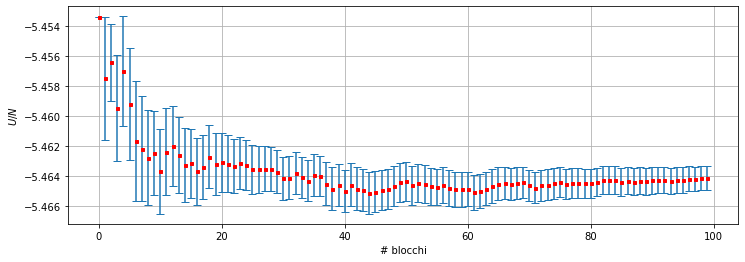

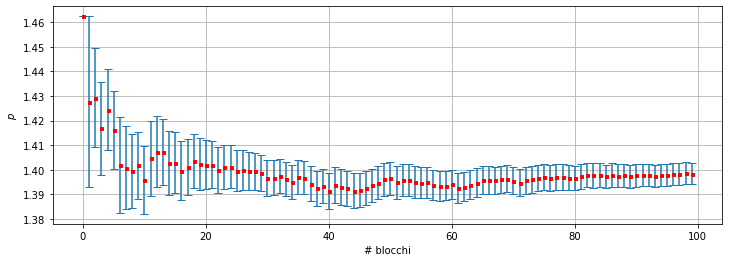

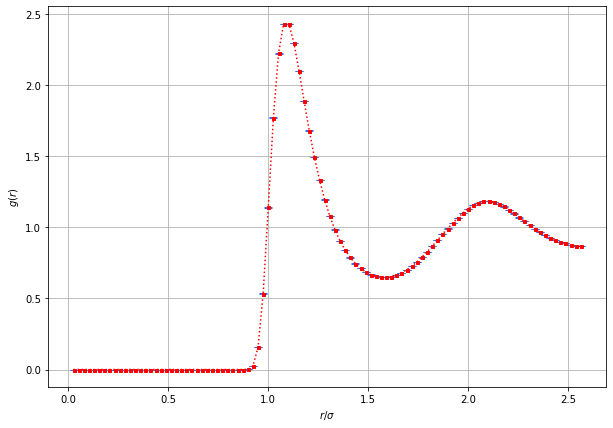

In [21]:

plt.figure(figsize=(12, 4))
plt.errorbar( N, E_l, yerr= errE_l, capsize= 4, marker= 's', mfc= 'red', mec= 'red', ms= 3, 
              linestyle= "none")
plt.xlabel('# blocchi')
plt.ylabel(r'$U/N$')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 4))
plt.errorbar( N, P_l, yerr= errP_l, capsize= 4, marker= 's', mfc= 'red', mec= 'red', ms= 3, 
              linestyle= "none")
plt.xlabel('# blocchi')
plt.ylabel(r'$p$')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 7))
plt.errorbar( r_l, G_l, yerr= errG_l, capsize= 4, marker= 's', mfc= 'red', mec= 'red', ms= 3, 
              linestyle= ":", ecolor= 'royalblue', color= "red")
plt.xlabel(r'$r/\sigma$')
plt.ylabel(r'$g(r)$')
plt.grid(True)
plt.show()


Si osserva quanto in precedenza per ciò che concerne gli andamenti delle variabili termodinamiche.

A proposito della $g(r)$ si osservi come l'andamento è similare a quello della fase solida, con le tipiche shell che tuttavia a grande distanza sembra oscillare intorno al valore 1, il che giustifica una correzione di coda  implementata nel codice, per una migliore rappresentatività del modello, ove $g(r_{\to \infty})=1.$

##### Fase gassosa:
Infine per la fase gassosa, si procede analogamente.

In [22]:

E_g, errE_g, P_g, errP_g= numpy.loadtxt( "7.2/out.gas.txt", usecols= (2,3,5,6), delimiter= "\t", unpack= 'true' )
r_g, G_g, errG_g= numpy.loadtxt( "7.2/out.g(x).gas.txt", usecols= (0,2,3), delimiter= "\t", unpack= 'true' )


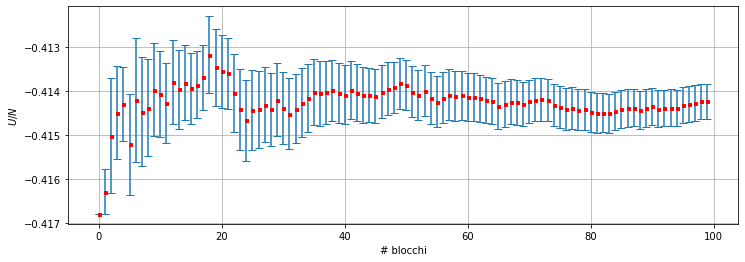

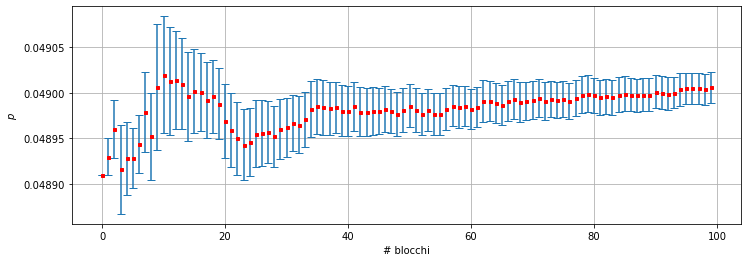

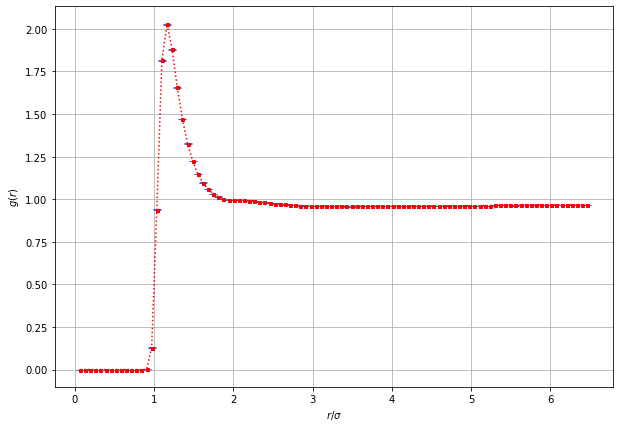

In [23]:

plt.figure(figsize=(12, 4))
plt.errorbar( N, E_g, yerr= errE_g, capsize= 4, marker= 's', mfc= 'red', mec= 'red', ms= 3, 
              linestyle= "none")
plt.xlabel('# blocchi')
plt.ylabel(r'$U/N$')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 4))
plt.errorbar( N, P_g, yerr= errP_g, capsize= 4, marker= 's', mfc= 'red', mec= 'red', ms= 3, 
              linestyle= "none")
plt.xlabel('# blocchi')
plt.ylabel(r'$p$')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 7))
plt.errorbar( r_g, G_g, yerr= errG_g, capsize= 4, marker= 's', mfc= 'red', mec= 'red', ms= 3, 
              linestyle= ":", ecolor= 'royalblue', color= "red")
plt.xlabel(r'$r/\sigma$')
plt.ylabel(r'$g(r)$')
plt.grid(True)
plt.show()


Le osservazioni precedenti restano nuovamente valide.

La tendenza a grandi distanze della funzione di distribuzione di struttura radiale, è qui ancor più evidente.

### -----------------------------------------------------------------------------------------------------------------------------------------------------------

# Comparazione MD e Monte Carlo NVT:

Implementata la stima della funzione di distribuzione radiale $g(r)$ nel codice di Dinamica Molecolare; ripetere la simulazione nelle tre fasi di un sistema di 108 particelle di Argon, con entrambi i codici (MD e Monte Carlo NTV) e confrontare alcune osservabili di interesse e le $g(r)$ prodotte. 

Fasi coinvolte:
- fase solida: $\rho^\star = 1.1$, $T^\star = 0.8$, $R_{cut-off}= 2.2$;
- fase liquida: $\rho^\star = 0.8$, $T^\star = 1.1$, $R_{cut-off}= 2.5$;
- fase gassosa: $\rho^\star = 0.05$, $T^\star = 1.2$, $R_{cut-off}= 5.0$;

Si definiscono alcune costanti legate all'Argon:
- m= 39.948 amu;
- $\sigma = 0.34$ nm;
- $\epsilon/k_B = 120$ K;

Si esprimano i risultati in unità del SI.

##### Fase solida:
Al fine di confrontare in maniera efficiente ed esauriente i due metodi di simulazione è necessario far coincidere le temperature di simulazione di tali metodi.\
Infatti, la simulazione di MD prevede un'integrazione secondo le equazioni del moto che portano un'evoluzione libera del sistema ad una temperatura stabile ma parzialmente incontrollabile (come già notato e sottolineato in una simulazione precedente).

In [24]:

from scipy.constants import Boltzmann

E_MD_s, errE_MD_s, T_MD_s, errT_MD_s, P_MD_s, errP_MD_s= numpy.loadtxt( "7.3+7.4/7.3 (Argon MD)/out.solid.txt", 
                                                                        usecols= (2,3,8,9,14,15), 
                                                                        delimiter= "\t", unpack= 'true' )
E_MRT2_s, errE_MRT2_s, P_MRT2_s, errP_MRT2_s= numpy.loadtxt( "7.3+7.4/7.4 (Argon M(RT)^2)/out.solid.txt", 
                                                                    usecols= (2,3,5,6), delimiter= "\t", 
                                                                    unpack= 'true' )
r_MD_g, G_MD_s, errG_MD_s= numpy.loadtxt( "7.3+7.4/7.3 (Argon MD)/out.g(x).solid.txt", usecols= (0,2,3), 
                                          delimiter= "\t", unpack= 'true' )
r_MRT2_g, G_MRT2_s, errG_MRT2_s= numpy.loadtxt( "7.3+7.4/7.4 (Argon M(RT)^2)/out.g(x).solid.txt", 
                                                usecols= (0,2,3), delimiter= "\t", unpack= 'true' )


sigma= 0.34*(10**9)
e_k= 120
e= e_k/Boltzmann
m= 39.948

E_MD_s*= e
errE_MD_s*= e
E_MRT2_s*= e 
errE_MRT2_s*= e

P_MD_s*= e/sigma**3
errP_MD_s*= e/sigma**3
P_MRT2_s*= e/sigma**3 
errP_MRT2_s*= e/sigma**3


In [25]:
print("Temperatura finale della simulazione di Dinamica Molecolare")
print("- valore medio (unità L-J):", T_MD_s[numpy.size(T_MD_s)-1])
print("- errore:                  ", errT_MD_s[numpy.size(errT_MD_s)-1])

Temperatura finale della simulazione di Dinamica Molecolare
- valore medio (unità L-J): 0.83597
- errore:                   3.8e-05


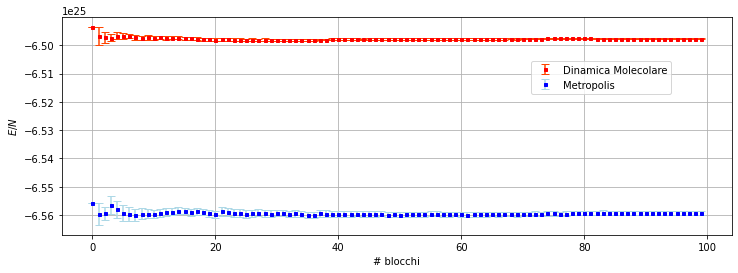

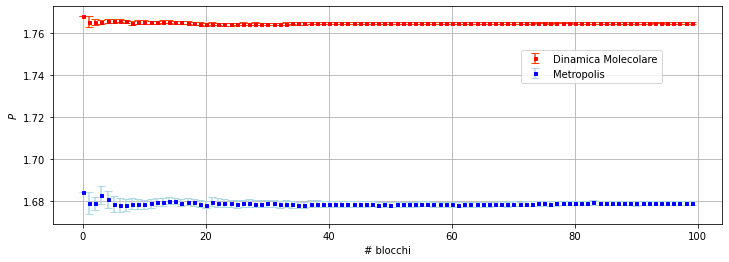

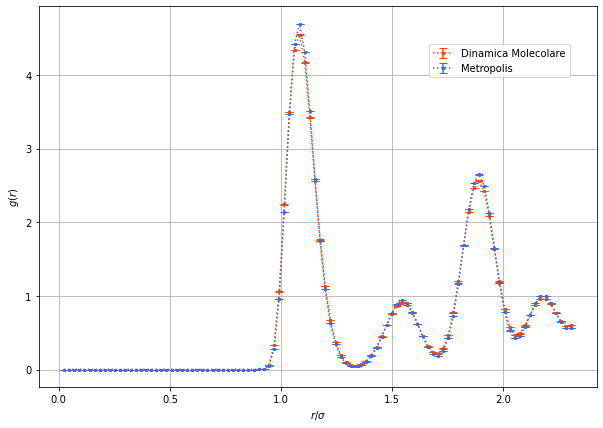

In [26]:

N_MD= numpy.arange(numpy.size(E_MD_s))
N_MRT2= numpy.arange(numpy.size(E_MRT2_s))

plt.figure(figsize=(12, 4))
plt.errorbar( N_MD, E_MD_s, yerr= errE_MD_s, capsize= 4, marker= 's', mfc= 'red', mec= 'red', ms= 3, 
              linestyle= "none", ecolor= "orangered", label= "Dinamica Molecolare")
plt.errorbar( N_MRT2, E_MRT2_s, yerr= errE_MRT2_s, capsize= 4, marker= 's', mfc= 'blue', mec= 'blue', ms= 3, 
              linestyle= "none", ecolor= "lightblue", label= "Metropolis")
plt.xlabel('# blocchi')
plt.ylabel(r'$E/N$')
plt.grid(True)
plt.legend(bbox_to_anchor=(0.7, 0.8), loc='upper left', borderaxespad=0.)
plt.show()

plt.figure(figsize=(12, 4))
plt.errorbar( N_MD, P_MD_s, yerr= errP_MD_s, capsize= 4, marker= 's', mfc= 'red', mec= 'red', ms= 3, 
              linestyle= "none", ecolor= "orangered", label= "Dinamica Molecolare")
plt.errorbar( N_MRT2, P_MRT2_s, yerr= errP_MRT2_s, capsize= 4, marker= 's', mfc= 'blue', mec= 'blue', ms= 3, 
              linestyle= "none", ecolor= "lightblue", label= "Metropolis")
plt.xlabel('# blocchi')
plt.ylabel(r'$P$')
plt.grid(True)
plt.legend(bbox_to_anchor=(0.7, 0.8), loc='upper left', borderaxespad=0.)
plt.show()


plt.figure(figsize=(10, 7))
plt.errorbar( r_MD_g, G_MD_s, yerr= errG_MD_s, capsize= 4, marker= 's', mfc= 'orangered', mec= 'orangered', 
              ms= 2, linestyle= ":", color= "orangered", label= "Dinamica Molecolare")
plt.errorbar( r_MRT2_g, G_MRT2_s, yerr= errG_MRT2_s, capsize= 4, marker= 's', mfc= 'royalblue', mec= 'royalblue',
              ms= 2, linestyle= ":", color= "royalblue", label= "Metropolis")
plt.xlabel(r'$r/\sigma$')
plt.ylabel(r'$g(r)$')
plt.grid(True)
plt.legend(bbox_to_anchor=(0.7, 0.9), loc='upper left', borderaxespad=0.)
plt.show()

Senza farsi ingannare dalle unità utilizzate, è però evidente che la temperatura target non è stata perfettamente raggiunta a causa delle problematiche intrinseche del codice di MD, ciò ha comportato un assestamento dei valori dell'energia e della pressione su valori specifici ma lontani tra le due simulazioni.

Ciò che effettivamente è tuttavia importante è valutare il grafico della funzione di distribuzione di struttura. In tale grafico, considerando gli errori associati, sebbene estremamente ridotti, i due algoritmi performano in maniera estremamente simile sulla scala di interesse riportata.

##### Liquido
Analogamente per la fase liquida.

In [27]:

E_MD_l, errE_MD_l, T_MD_l, errT_MD_l, P_MD_l, errP_MD_l= numpy.loadtxt( "7.3+7.4/7.3 (Argon MD)/out.liquid.txt", 
                                                                        usecols= (2,3,8,9,14,15), 
                                                                        delimiter= "\t", unpack= 'true' )
E_MRT2_l, errE_MRT2_l, P_MRT2_l, errP_MRT2_l= numpy.loadtxt( "7.3+7.4/7.4 (Argon M(RT)^2)/out.liquid.txt", 
                                                             usecols= (2,3,5,6), delimiter= "\t", unpack= 'true' )
r_MD_l, G_MD_l, errG_MD_l= numpy.loadtxt( "7.3+7.4/7.3 (Argon MD)/out.g(x).liquid.txt", usecols= (0,2,3), 
                                          delimiter= "\t", unpack= 'true' )
r_MRT2_l, G_MRT2_l, errG_MRT2_l= numpy.loadtxt( "7.3+7.4/7.4 (Argon M(RT)^2)/out.g(x).liquid.txt", 
                                                usecols= (0,2,3), delimiter= "\t", unpack= 'true' )

sigma= 0.34*(10**9)
e_k= 120
e= e_k/Boltzmann
m= 39.948

E_MD_l*= e
errE_MD_l*= e
E_MRT2_l*= e 
errE_MRT2_l*= e

P_MD_l*= e/sigma**3 
errP_MD_l*= e/sigma**3
P_MRT2_l*= e/sigma**3
errP_MRT2_l*= e/sigma**3


In [28]:
print("Temperatura finale della simulazione di Dinamica Molecolare")
print("- valore medio (unità di L-J):", T_MD_l[numpy.size(T_MD_l)-1])
print("- errore:                     ", errT_MD_l[numpy.size(errT_MD_l)-1])

Temperatura finale della simulazione di Dinamica Molecolare
- valore medio (unità di L-J): 1.098426
- errore:                      8.2e-05


In questa simulazione la temperatura target è stata centrata in maniera leggermente migliore, il che induce a pensare che i grafici potranno essere più similari, fermo restando che l'attenzione debba essere concentrata in particolare sulla funzione $g(x)$.

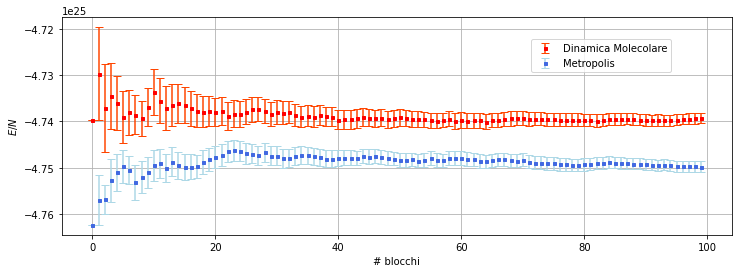

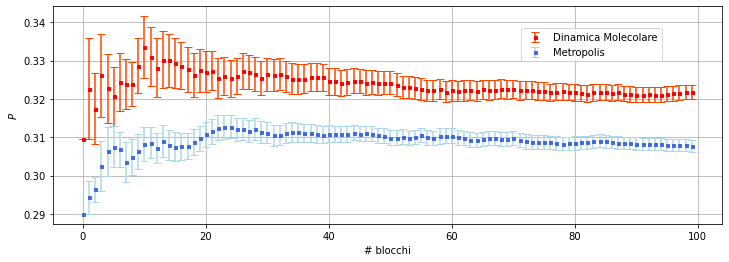

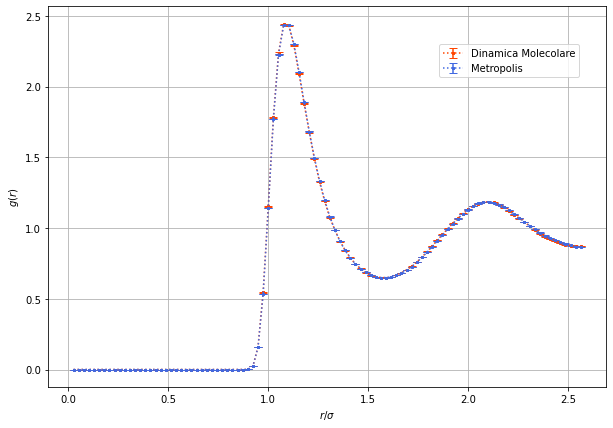

In [29]:

plt.figure(figsize=(12, 4))
plt.errorbar( N_MD, E_MD_l, yerr= errE_MD_l, capsize= 4, marker= 's', mfc= 'red', mec= 'red', ms= 3, 
              linestyle= "none", ecolor= "orangered", label= "Dinamica Molecolare")
plt.errorbar( N_MRT2, E_MRT2_l, yerr= errE_MRT2_l, capsize= 4, marker= 's', mfc= 'royalblue', mec= 'royalblue', 
              ms= 3, linestyle= "none", ecolor= "lightblue", label= "Metropolis")
plt.xlabel('# blocchi')
plt.ylabel(r'$E/N$')
plt.grid(True)
plt.legend(bbox_to_anchor=(0.7, 0.9), loc='upper left', borderaxespad=0.)
plt.show()

plt.figure(figsize=(12, 4))
plt.errorbar( N_MD, P_MD_l, yerr= errP_MD_l, capsize= 4, marker= 's', mfc= 'red', mec= 'red', ms= 3, 
              linestyle= "none", ecolor= "orangered", label= "Dinamica Molecolare")
plt.errorbar( N_MRT2, P_MRT2_l, yerr= errP_MRT2_l, capsize= 4, marker= 's', mfc= 'royalblue', mec= 'royalblue', 
              ms= 3, linestyle= "none", ecolor= "lightblue", label= "Metropolis")
plt.xlabel('# blocchi')
plt.ylabel(r'$P$')
plt.grid(True)
plt.legend(bbox_to_anchor=(0.7, 0.9), loc='upper left', borderaxespad=0.)
plt.show()

plt.figure(figsize=(10, 7))
plt.errorbar( r_MD_l, G_MD_l, yerr= errG_MD_l, capsize= 4, marker= 's', mfc= 'orangered', mec= 'orangered', 
              ms= 2, linestyle= ":", color= "orangered", label= "Dinamica Molecolare")
plt.errorbar( r_MRT2_l, G_MRT2_l, yerr= errG_MRT2_l, capsize= 4, marker= 's', mfc= 'royalblue', mec= 'royalblue',
              ms= 2, linestyle= ":", color= "royalblue", label= "Metropolis")
plt.xlabel(r'$r/\sigma$')
plt.ylabel(r'$g(r)$')
plt.grid(True)
plt.legend(bbox_to_anchor=(0.7, 0.9), loc='upper left', borderaxespad=0.)
plt.show()


Come si è notato in precedenza avendo centrato in maniera migliore rispetto alla fase solida la temperatura target della simulazione effettuato con il codice di MD il grafico della funzione di distribuzione di struttura, considerando gli errori risultano estremamente simili sulla scala di performance richiesta. Anche i grafici delle variabili termodinamiche appaiono più simili tra loro, ma soprattutto convergenti e con errore decrescente nel numero di blocchi considerati.

##### Fase gassosa:

In [30]:

E_MD_g, errE_MD_g, T_MD_g, errT_MD_g, P_MD_g, errP_MD_g= numpy.loadtxt( "7.3+7.4/7.3 (Argon MD)/out.gas.txt", 
                                                                        usecols= (2,3,8,9,14,15), 
                                                                        delimiter= "\t", unpack= 'true' )
E_MRT2_g, errE_MRT2_g, P_MRT2_g, errP_MRT2_g= numpy.loadtxt( "7.3+7.4/7.4 (Argon M(RT)^2)/out.gas.txt", 
                                                                    usecols= (2,3,5,6), delimiter= "\t", 
                                                                    unpack= 'true' )
r_MD_g, G_MD_g, errG_MD_g= numpy.loadtxt( "7.3+7.4/7.3 (Argon MD)/out.g(x).gas.txt", usecols= (0,2,3), 
                                          delimiter= "\t", unpack= 'true' )
r_MRT2_g, G_MRT2_g, errG_MRT2_g= numpy.loadtxt( "7.3+7.4/7.4 (Argon M(RT)^2)/out.g(x).gas.txt", usecols= (0,2,3), 
                                          delimiter= "\t", unpack= 'true' )

sigma= 0.34*(10**9)
e_k= 120
e= e_k/Boltzmann
m= 39.948

E_MD_g*= e
errE_MD_g*= e
E_MRT2_g*= e 
errE_MRT2_g*= e

P_MD_g*= e/sigma**3
errP_MD_g*= e/sigma**3
P_MRT2_g*= e/sigma**3
errP_MRT2_g*= e/sigma**3


In [31]:
print("Temperatura finale della simulazione di Dinamica Molecolare")
print("- valore medio (unità L-J):", T_MD_g[numpy.size(T_MD_g)-1])
print("- errore:                  ", errT_MD_g[numpy.size(errT_MD_g)-1])

Temperatura finale della simulazione di Dinamica Molecolare
- valore medio (unità L-J): 1.260143
- errore:                   6e-06


La temperatura target di un sistema gassoso nelle condizioni sopra-riportate estremamente vicine al passaggio di stato è estremamente complessa da centrare, oltretutto su una simulazione limitata di un sistema che presenta (come notato in una simulazione precedente) enormi oscillazioni periodiche.

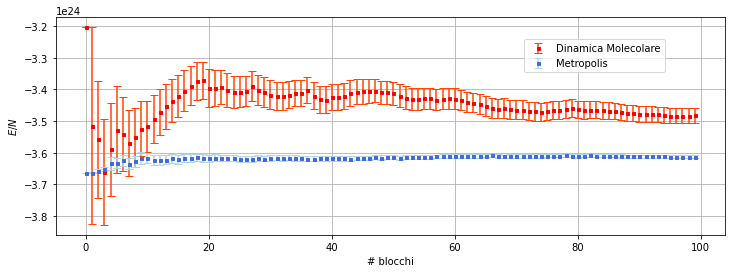

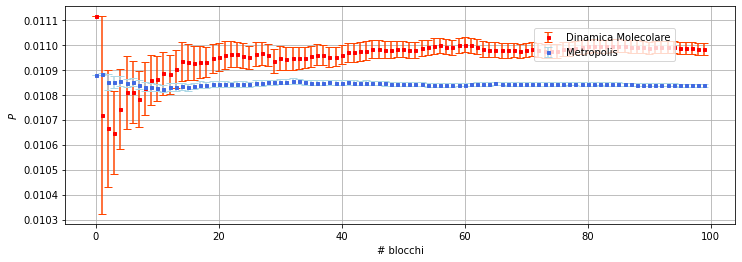

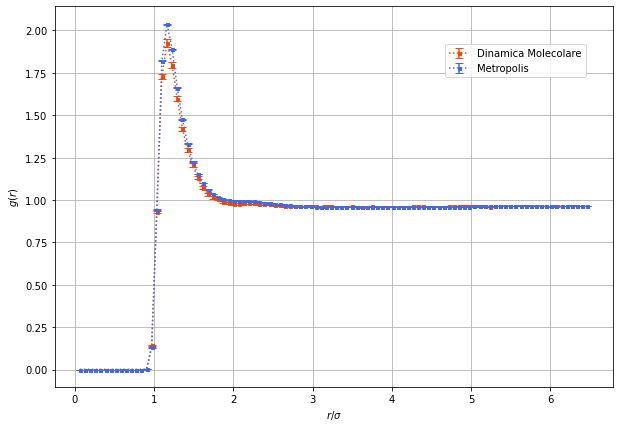

In [32]:

plt.figure(figsize=(12, 4))
plt.errorbar( N_MD, E_MD_g, yerr= errE_MD_g, capsize= 4, marker= 's', mfc= 'red', mec= 'red', ms= 3, 
              linestyle= "none", ecolor= "orangered", label= "Dinamica Molecolare")
plt.errorbar( N_MRT2, E_MRT2_g, yerr= errE_MRT2_g, capsize= 4, marker= 's', mfc= 'royalblue', 
              mec= 'royalblue', ms= 3, linestyle= "none", ecolor= "lightblue", label= "Metropolis")
plt.xlabel('# blocchi')
plt.ylabel(r'$E/N$')
plt.grid(True)
plt.legend(bbox_to_anchor=(0.7, 0.9), loc='upper left', borderaxespad=0.)
plt.show()

plt.figure(figsize=(12, 4))
plt.errorbar( N_MD, P_MD_g, yerr= errP_MD_g, capsize= 4, marker= 's', mfc= 'red', mec= 'red', ms= 3, 
              linestyle= "none", ecolor= "orangered", label= "Dinamica Molecolare")
plt.errorbar( N_MRT2, P_MRT2_g, yerr= errP_MRT2_g, capsize= 4, marker= 's', mfc= 'royalblue',
              mec= 'royalblue', ms= 3, linestyle= "none", ecolor= "lightblue", label= "Metropolis")
plt.xlabel('# blocchi')
plt.ylabel(r'$P$')
plt.grid(True)
plt.legend(bbox_to_anchor=(0.7, 0.9), loc='upper left', borderaxespad=0.)
plt.show()

plt.figure(figsize=(10, 7))
plt.errorbar( r_MD_g, G_MD_g, yerr= errG_MD_g, capsize= 4, marker= 's', mfc= 'orangered', mec= 'orangered', 
             ms= 3, linestyle= ":", ecolor= 'orangered', color= "orangered", label= "Dinamica Molecolare")
plt.errorbar( r_MRT2_g, G_MRT2_g, yerr= errG_MRT2_g, capsize= 4, marker= 's', mfc= 'royalblue', 
              mec= 'royalblue', ms= 3, linestyle= ":", ecolor= 'royalblue', color= "royalblue", 
              label= "Metropolis")
plt.xlabel(r'$r/\sigma$')
plt.ylabel(r'$g(r)$')
plt.grid(True)
plt.legend(bbox_to_anchor=(0.7, 0.9), loc='upper left', borderaxespad=0.)
plt.show()


La simulazione del sistema gassoso con il codice di MD, come detto è estremamente complessa, tuttavia la comparazione della funzione $g(r)$ appare comunque consistente.

Gli andamenti delle osservabili termodinamiche, invece, appaiono più distanti anche causa delle unità di misura SI utilizzate.
